In [1]:
import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)

In [3]:
exp.xdata_files = np.delete(exp.xdata_files,-3)
exp.ydata_files =  np.delete(exp.ydata_files,-3)
exp.info_files = np.delete(exp.info_files, -3)
# exp.behavior_files = np.delete(exp.behavior_files, -3)
exp.nsub = len(exp.xdata_files)

In [5]:
time_window = 50
time_step = 25
trial_bin_size = 20
n_splits = 30
group_dict = OrderedDict([('1',[11]),('1 (hashtag)',[12]),('1 (letter)',[13]),('1 (flip)',[14]),('Set size 2',[20])])
train_labels = ['1','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [6]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
        wrangl.ifold+=1

0
1
2
3
4
5
6
7
8
9


In [7]:
interp = eeg_decoder.Interpreter(clfr)
# interp.save_results()

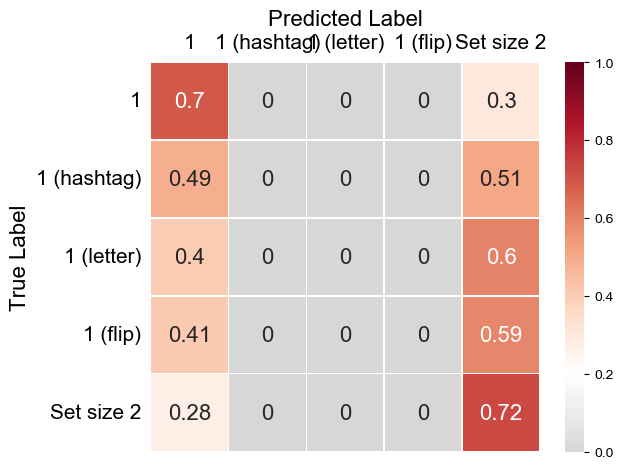

In [8]:
interp.plot_confusion_matrix()

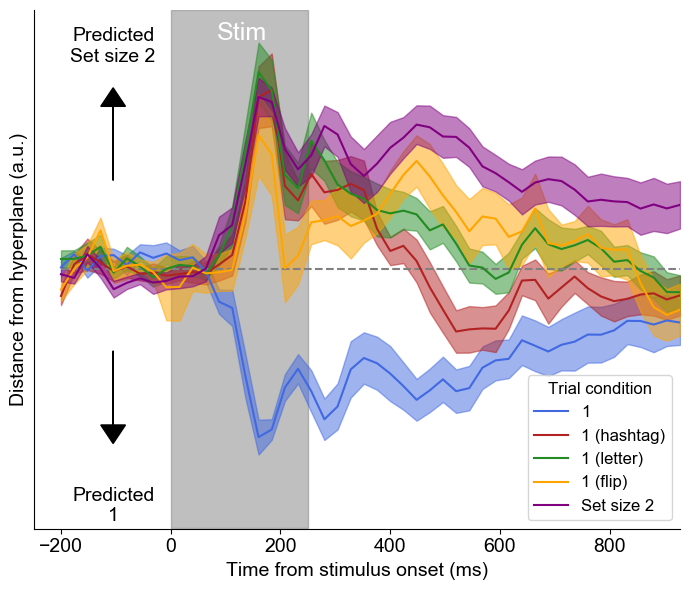

In [9]:
interp.plot_hyperplane(ylim=[-3.5,3.5],stim_label_xy=[130,3.1],figsize=[7,6])

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
means = np.mean(np.mean(interp.confidence_scores,2)[:,(interp.t<1900)&(interp.t>500)],1)


In [11]:
df = pd.DataFrame(means)

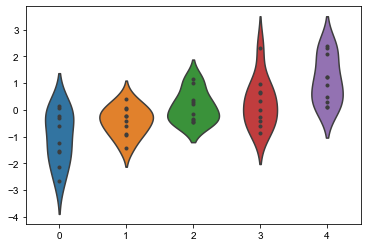

In [12]:
sns.violinplot(data=df,inner='points')